### PCA in Machine Learning Workflows
#### Machine Learning I - Maestría en Analítica Aplicada
#### Universidad de la Sabana
#### Prof: Hugo Franco
#### Exercise: Dealing with Class Imbalance II

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


1. Data Loading
Start by importing the libraries and loading the dataset and describe its contents

In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

Dataset Shape: (7043, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  P

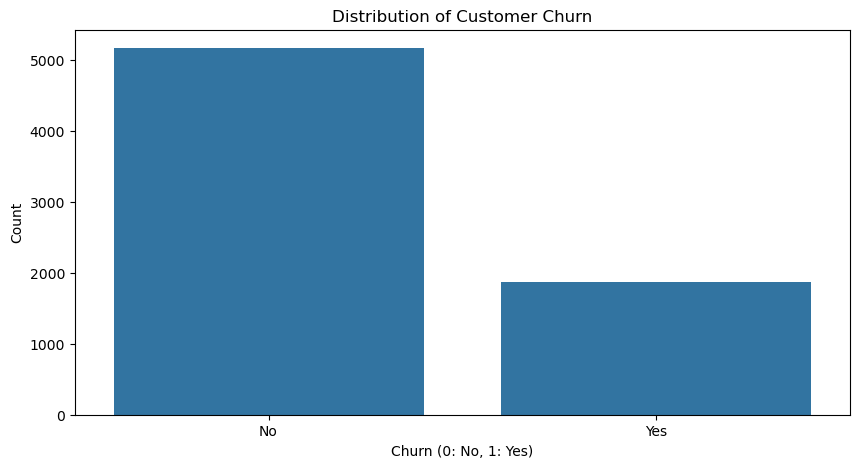


Missing Values:
No missing values detected.


In [3]:
# Dataset Overview Analysis
print("Dataset Shape:", df.shape)

# Identify feature types for reporting
numerical_features_overview = df.select_dtypes(include=np.number).columns.tolist()
categorical_features_overview = df.select_dtypes(exclude=np.number).columns.tolist()

# Display general information about the dataset
print("\nDataset Info:")
print(df.info())

# Show class distribution
print("\nChurn Distribution:")
print(df['Churn'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

# Display summary statistics for numerical features
if numerical_features_overview:
    print("\nNumerical Features Summary:")
    print(df[numerical_features_overview].describe())
else:
    print("\nNo numerical features available before preprocessing.")

# Show unique values in categorical features
if categorical_features_overview:
    print("\nCategorical Features Overview:")
    for col in categorical_features_overview:
        print(f"\n{col} unique values:")
        print(df[col].value_counts())
else:
    print("\nNo categorical features available before preprocessing.")

# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Churn')
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# Display missing values if any
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0]) if missing_values.any() else print("No missing values detected.")

2. Data Preprocessing

Necessary preprocessing steps to clean the data and prepare it for the pipeline.

In [4]:
# --- Data Preprocessing ---

# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Handle 'TotalCharges' column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Convert 'Churn' and 'gender' to binary
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    # Keep the remaining columns (if any) unchanged
    remainder='passthrough'
)

# Split the data before applying any transformations
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

3. Build and Train the XGBoost Pipeline
Here, we define our three-step pipeline. When we call `.fit()`, it will automatically preprocess the data, apply SMOTE to the results, and then train the XGBoost classifier on the balanced data.

In [5]:
# --- Build and Train the Pipeline ---

# Create the full pipeline with SMOTE and XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Train the pipeline
xgb_pipeline.fit(X_train, y_train)

print("Pipeline training completed.")

c:\Users\Alejandro\miniconda3\envs\bigdata_sql\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:55] WARNING: D:\bld\xgboost-split_1737531311373\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline training completed.


4. Evaluate the Model
Finally, we use the trained pipeline to make predictions on the untouched test set and evaluate its performance.

In [11]:
# --- Final Model Evaluation ---

# Make predictions on the test set
y_pred = xgb_pipeline.predict(X_test)
y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# Print the performance metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

cm_smote = confusion_matrix(y_test, y_pred, normalize='true')

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.3f}")

Classification Report:

              precision    recall  f1-score   support

    No Churn       0.86      0.85      0.85      1033
       Churn       0.60      0.60      0.60       374

    accuracy                           0.79      1407
   macro avg       0.73      0.73      0.73      1407
weighted avg       0.79      0.79      0.79      1407

ROC AUC Score: 0.825


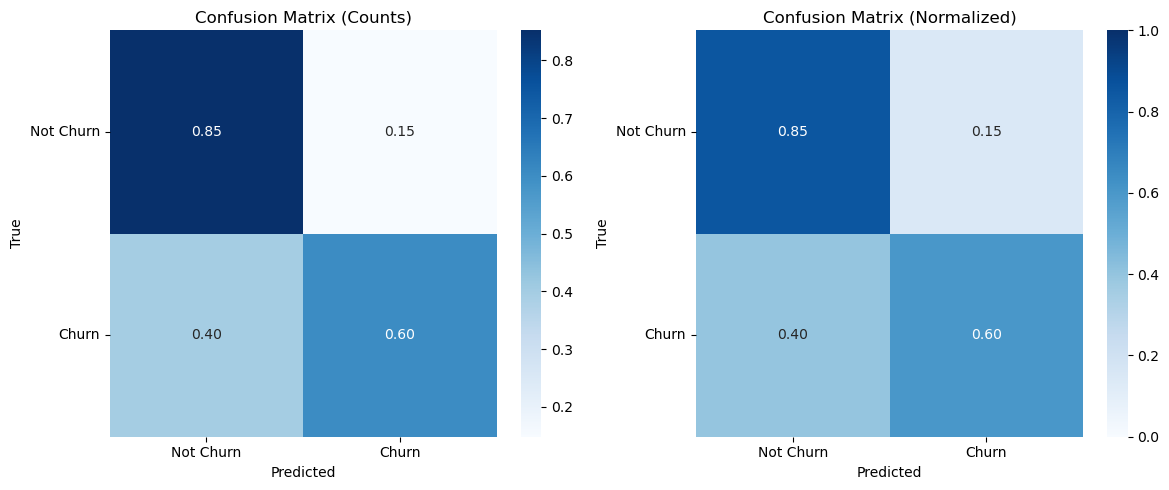

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz sin normalizar
sns.heatmap(cm_smote, annot=True, fmt='.2f', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Matriz normalizada
sns.heatmap(cm_smote, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Etiquetas de clases
class_names = ['Not Churn', 'Churn']
for ax in axes:
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names, rotation=0)

plt.tight_layout()
plt.show()
